In [1]:
#import necessary package
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

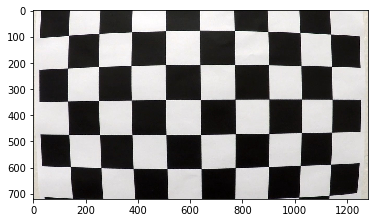

In [20]:
img = plt.imread('C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\camera_cal\calibration1.jpg')
plt.imshow(img)
objpoints = [] # 3D points in real life
imgpoints = [] # 2D points in image

In [12]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
        
    else:
        print('cant find distorted image points')

    # Return the resulting image and matrix
    return warped, M

In [13]:
#Goal
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

#Formatting
#img should be read my plt.imread, make sure it's BGR format
#objpoints & imgpoints are empty list

def cal_undistort_unwarped(img, objpoints, imgpoints, nx, ny):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = np.copy(img)  # Delete this line
    undist_gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    
    #define image object points
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    ret, corners = cv2.findChessboardCorners(undist_gray, (nx,ny), None)

    #if function detects the chessboard points, append two set of points into the original set
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    else:
        print('cant find image corners')
        
    cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, undist_gray.shape[::-1], None, None)
    undistorted = cv2.undistort(undist, mtx, dist, None, mtx)
    
    #using corners_unwarp to transform the image 
    warped_img,M = corners_unwarp(img, nx, ny, mtx, dist)

    return warped_img,M

In [21]:
warped_img,M = cal_undistort_unwarped(img, objpoints, imgpoints, nx=9, ny=5)

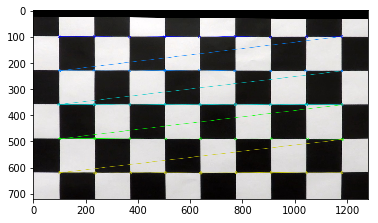

In [16]:
plt.imshow(warped_img)

In [ ]:
plt.imshow(warped)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def tellme(self):
        if self.detected == True:
            print('true')
        else:
            print('False')